In [ ]:
from google.colab import drive
!pip install torchnet
!pip install visdom
drive.mount('/content/gdrive')

     |████████████████████████████████| 686kB 14.3MB/s 
     |████████████████████████████████| 204kB 56.3MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp36-none-any.whl size=29744 sha256=846236ae38eb4021ff1c0432880a7755bc26dbf1d78bcb6913c1705938f9eaf4
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655250 sha256=998c763be015a5a5b61159de2368b3dcdab12dc9d73242a6f449e62084727f91
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=2285a82d4000f644cfcb5d52a91b9e785ba1ac4d167e49f98ee606493bfef944
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile
Go to this URL in a browser: https://accounts.google.com/

### Settings

In [ ]:
def unpickle(file):
    import _pickle as cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict
rootPath =  '/content/gdrive/My Drive/DS1013NoisyLabel/cifar-10'
import sys
sys.path.append('/content/gdrive/My Drive/DS1013NoisyLabel/')

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
import os
import argparse
import numpy as np
import pandas as pd
from scipy.ndimage import rotate
from PreResNet_self_semi import *
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import scipy.stats as stats

parser = argparse.ArgumentParser(description='PyTorch CIFAR Training')
parser.add_argument('--batch_size', default=64, type=int, help='train batchsize') 
parser.add_argument('--lr', '--learning_rate', default=0.02, type=float, help='initial learning rate')
parser.add_argument('--noise_mode',  default='sym')
parser.add_argument('--num_epochs', default=300, type=int)
parser.add_argument('--r', default=0.8, type=float, help='noise ratio')
parser.add_argument('--id', default='')
parser.add_argument('--seed', default=123)
parser.add_argument('--gpuid', default=0, type=int)
parser.add_argument('--num_class', default=10, type=int)
parser.add_argument('--num_rotation', default=4, type=int)
parser.add_argument('--data_path', default='./cifar-10', type=str, help='path to dataset')
parser.add_argument('--dataset', default='cifar10', type=str)

args = parser.parse_args(args=[])
torch.cuda.set_device(args.gpuid)

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)


### DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
from scipy.ndimage import rotate
import json
import os
import torch
from torchnet.meter import AUCMeter
from itertools import chain

class cifar_dataset(Dataset): 
    def __init__(self, dataset, r, noise_mode, root_dir, transform, mode, noise_file='', pred=[], probability=[], log=''): 
        
        self.r = r # noise ratio
        self.transform = transform
        self.mode = mode  
        self.transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} # class transition for asymmetric noise
     
        if self.mode=='test' or self.mode=='test_average':
            if dataset=='cifar10':                
                test_dic = unpickle('%s/test_batch'%root_dir)
                self.test_data = test_dic['data']
                self.test_data = self.test_data.reshape((10000, 3, 32, 32))
                self.test_data = self.test_data.transpose((0, 2, 3, 1))
                self.test_label = test_dic['labels']
            elif dataset=='cifar100':
                test_dic = unpickle('%s/test'%root_dir)
                self.test_data = test_dic['data']
                self.test_data = self.test_data.reshape((10000, 3, 32, 32))
                self.test_data = self.test_data.transpose((0, 2, 3, 1))
                self.test_label = test_dic['fine_labels']
        
        else:
            train_data = []
            train_label = []
            if dataset=='cifar10': 
                for n in range(1,6):
                    dpath = '%s/data_batch_%d'%(root_dir,n)
                    data_dic = unpickle(dpath)
                    train_data.append(data_dic['data'])
                    train_label = train_label+data_dic['labels']
                train_data = np.concatenate(train_data)
            elif dataset=='cifar100':    
                train_dic = unpickle('%s/train'%root_dir)
                train_data = train_dic['data']
                train_label = train_dic['fine_labels']
            train_data = train_data.reshape((50000, 3, 32, 32))
            train_data = train_data.transpose((0, 2, 3, 1))

            if self.mode == 'eval' or self.mode == 'eval_average':
                self.eval_data = train_data[45000:]
                self.eval_label = train_label[45000:]

            else:
                if os.path.exists(noise_file):
                    noise_label = json.load(open(noise_file,"r"))
                else:    # inject noise   
                    noise_label = []
                    if self.mode in ['all', 'benchmark_all', 'benchmark_all_average']:
                      size = 50000
                    elif self.mode in ['train', 'benchmark', 'benchmark_average']:
                      size = 45000
                    idx = list(range(size))
                    random.shuffle(idx)
                    num_noise = int(self.r*size)            
                    noise_idx = idx[:num_noise]
                    for i in range(size):
                        if i in noise_idx:
                            if noise_mode=='sym':
                                if dataset=='cifar10': 
                                    noiselabel = random.randint(0,9)
                                elif dataset=='cifar100':    
                                    noiselabel = random.randint(0,99)
                                noise_label.append(noiselabel)
                            elif noise_mode=='asym':   
                                noiselabel = self.transition[train_label[i]]
                                noise_label.append(noiselabel)                    
                        else:    
                            noise_label.append(train_label[i])   
                    print("save noisy labels to %s ..."%noise_file)        
                    json.dump(noise_label,open(noise_file,"w"))       

                if self.mode in ['all', 'benchmark_all', 'benchmark_all_average']:
                    self.train_data = train_data
                    self.noise_label = noise_label
                    self.clean_label = train_label
            
                elif self.mode in ['train', 'benchmark', 'benchmark_average']:
                    self.train_data = train_data[:45000]
                    self.noise_label = noise_label[:45000]
                    self.clean_label = train_label[:45000]
                    
                else:                   
                    if self.mode == "labeled":
                        pred_idx = pred.nonzero()[0]
                        self.probability = [probability[i] for i in pred_idx]
                    
                        clean = (np.array(noise_label)==np.array(train_label))                                                       
                        auc_meter = AUCMeter()
                        auc_meter.reset()
                        auc_meter.add(probability,clean)        
                        auc,_,_ = auc_meter.value()               
                        log.write('Numer of labeled samples:%d   AUC:%.3f\n'%(pred.sum(),auc))
                        log.flush()      
                    
                    elif self.mode == "unlabeled":
                        pred_idx = (1-pred).nonzero()[0]                                             
                
                    self.train_data = train_data[pred_idx]
                    self.noise_label = [noise_label[i] for i in pred_idx]                          
                    print("%s data has a size of %d"%(self.mode,len(self.noise_label)))            
                

    def __getitem__(self, index):

        if self.mode == 'eval_average':
            img, target = self.eval_data[index], self.eval_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            angle = [0, 90, 180, 270]
            img1 = rotate(img, 90, axes=(1,2), reshape=False)
            img2 = rotate(img, 180, axes=(1,2), reshape=False)
            img3 = rotate(img, 270, axes=(1,2), reshape=False)
            return img, img1, img2, img3, target, index

        elif self.mode=='test_average':
            img, target = self.test_data[index], self.test_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            angle = [0, 90, 180, 270]
            img1 = rotate(img, 90, axes=(1,2), reshape=False)
            img2 = rotate(img, 180, axes=(1,2), reshape=False)
            img3 = rotate(img, 270, axes=(1,2), reshape=False)
            return img, img1, img2, img3, target, index

        elif self.mode=='eval':
            img, target = self.eval_data[index], self.eval_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target, index

        elif self.mode=='test':
            img, target = self.test_data[index], self.test_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target, index
        
        elif self.mode=='benchmark_average' or self.mode=='benchmark_all_average':
            img, target, target_clean = self.train_data[index], self.noise_label[index], self.clean_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            angle = [0, 90, 180, 270]
            img1 = rotate(img, 90, axes=(1,2), reshape=False)
            img2 = rotate(img, 180, axes=(1,2), reshape=False)
            img3 = rotate(img, 270, axes=(1,2), reshape=False)
            target_rot = [0, 1, 2, 3]
            return img, img1, img2, img3, target, target_rot, target_clean, index

        elif self.mode=='benchmark' or self.mode=='benchmark_all':
            img, target, target_clean = self.train_data[index], self.noise_label[index], self.clean_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            target_rot = 0
            return img, target, target_rot, target_clean, index

        else: # labeled, unlabeled, all, train
            img, target, target_clean = self.train_data[index], self.noise_label[index], self.clean_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)

            angle = [0, 90, 180, 270]
            target_rot = np.random.choice([0, 1, 2, 3])
            img = rotate(img, angle[target_rot], axes=(1,2), reshape=False)
            return img, target, target_rot, target_clean, index
           
    def __len__(self):
        if self.mode in ['test', 'test_average']:
            return len(self.test_data)
        elif self.mode in ['eval', 'eval_average']:
            return len(self.eval_data)
        else:
            return len(self.train_data)


class cifar_dataloader():  
    def __init__(self, dataset, r, noise_mode, batch_size, num_workers, root_dir, log, noise_file=''):
        self.dataset = dataset
        self.r = r
        self.noise_mode = noise_mode
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root_dir = root_dir
        self.log = log
        self.noise_file = noise_file
        if self.dataset=='cifar10':
            self.transform_train = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
                ]) 
            self.transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
                ])    
        elif self.dataset=='cifar100':    
            self.transform_train = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
                ]) 
            self.transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
                ])   
            
    def run(self,mode,pred=[],prob=[]):
        if mode=='warmup_all':
            all_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="benchmark_all",noise_file=self.noise_file)                
            trainloader = DataLoader(
                dataset=all_dataset, 
                batch_size=self.batch_size*2,
                shuffle=True,
                num_workers=self.num_workers)             
            return trainloader

        elif mode=='warmup':
            train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="benchmark",noise_file=self.noise_file)                
            trainloader = DataLoader(
                dataset=train_dataset, 
                batch_size=self.batch_size*2,
                shuffle=True,
                num_workers=self.num_workers)             
            return trainloader

        elif mode=='train_all':
            all_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="all",noise_file=self.noise_file)                
            trainloader = DataLoader(
                dataset=all_dataset, 
                 batch_size=self.batch_size*2,
                 shuffle=True,
                num_workers=self.num_workers)             
            return trainloader
        elif mode=='train':
            train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="train",noise_file=self.noise_file)                
            trainloader = DataLoader(
                dataset=train_dataset, 
                batch_size=self.batch_size*2,
                shuffle=True,
                num_workers=self.num_workers)             
            return trainloader
                                     
        elif mode=='train_separate':
            labeled_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="labeled", noise_file=self.noise_file, pred=pred, probability=prob, log=self.log)              
            labeled_trainloader = DataLoader(
                dataset=labeled_dataset, 
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=self.num_workers)   
            
            unlabeled_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_train, mode="unlabeled", noise_file=self.noise_file, pred=pred)                    
            unlabeled_trainloader = DataLoader(
                dataset=unlabeled_dataset, 
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=self.num_workers)     
            return labeled_trainloader, unlabeled_trainloader

        elif mode=='eval_train_all':
            eval_train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='benchmark_all', noise_file=self.noise_file)      
            eval_train_loader = DataLoader(
                dataset=eval_train_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_train_loader

        elif mode=='eval_train':
            eval_train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='benchmark', noise_file=self.noise_file)      
            eval_train_loader = DataLoader(
                dataset=eval_train_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_train_loader

        elif mode=='eval':
            eval_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='eval')      
            eval_loader = DataLoader(
                dataset=eval_dataset, 
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_loader

        elif mode=='test':
            test_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='test')      
            test_loader = DataLoader(
                dataset=test_dataset, 
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return test_loader
        
        elif mode=='eval_train_all_average':
            eval_train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='benchmark_all_average', noise_file=self.noise_file)      
            eval_train_loader = DataLoader(
                dataset=eval_train_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_train_loader

        elif mode=='eval_train_average':
            eval_train_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='benchmark_average', noise_file=self.noise_file)      
            eval_train_loader = DataLoader(
                dataset=eval_train_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_train_loader

        elif mode=='eval_average':
            eval_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='eval_average')      
            eval_loader = DataLoader(
                dataset=eval_dataset, 
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return eval_loader

        elif mode=='test_average':
            test_dataset = cifar_dataset(dataset=self.dataset, noise_mode=self.noise_mode, r=self.r, root_dir=self.root_dir, transform=self.transform_test, mode='test_average')      
            test_loader = DataLoader(
                dataset=test_dataset, 
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers)
            return test_loader

### Functions

In [ ]:
def train(epoch, net, optimizer, dataloader, accs, prob_dict, alpha, loss_function = 'prob_Reg'):
    net.train()
    
    total, correct, clean_total, noisy_total, clean_correct, noisy_correct, noisy_noisy = 0, 0, 0, 0, 0, 0, 0
    all_train_acc = accs[0]
    clean_train_acc = accs[1]
    noisy_train_acc = accs[2]
    noisy_train_noisy = accs[3]

    if alpha == 'linear':
      alpha = 0.005 * epoch

    num_iter = (len(dataloader.dataset)//dataloader.batch_size)+1
    rot_labels_list, path_list = [], []
    for batch_idx, (inputs, labels, rot_labels, clean_labels, path) in enumerate(dataloader):
        rot_labels_list += rot_labels.tolist()
        path_list += path.tolist()
        inputs, labels, rot_labels, clean_labels = inputs.cuda(), labels.cuda(), rot_labels.cuda(), clean_labels.cuda()
        optimizer.zero_grad()
        output1, output2 = net(inputs)
        
        if not prob_dict:
          lamb = torch.ones(labels.shape)
        else:
          lamb = []
          for p in path:
            lamb.append(prob_dict[int(p)])
          lamb = torch.FloatTensor(lamb)
        lamb = lamb.cuda()

        ######################  SELECT LOSS FUNCTION  ######################
        # CE of labels only
        if loss_function == 'CE':
          loss = CEloss(output1, labels)
        # fixed weight for CE of rotations
        elif loss_function == 'fix_Reg':
          loss = CEloss(output1, labels) +  alpha * CEloss(output2, rot_labels)
        # CE of labels and probability-based CE of rotations
        elif loss_function == 'prob_Reg':
          loss = CE(output1, labels) +  alpha * (1 - lamb) * CE(output2, rot_labels)
          loss = torch.mean(loss)
        # probability-based CE of labels and probability-based CE of rotations
        elif loss_function == 'prob_weighted':
          loss = torch.mul(lamb, CE(output1, labels)) +  torch.mul((1 - lamb), CE(output2, rot_labels))
          loss = torch.mean(loss)
        # separate clean and noisy (by setting lamb as a 0-1 vector)
        elif loss_function == 'separate':
          n1, n2 = len(torch.nonzero(lamb)), len(torch.nonzero(1 - lamb))
          if n1!=0 and n2!=0:
            loss = torch.sum(lamb * CE(output1, labels)) / n1 + torch.sum((1 - lamb) * CE(output2, rot_labels)) / n2
          elif n1!=0:
            loss = CEloss(output1, labels)
          elif n2!=0:
            print('All noisy?')
            loss = CEloss(output2, rot_labels)
        # probability-based CE of labels only
        elif loss_function == 'prob_CE':
          loss = torch.mul(lamb, CE(output1, labels))
          loss = torch.mean(loss)
        ####################################################################

        if args.noise_mode=='asym':  # penalize confident prediction for asymmetric noise
            penalty = conf_penalty(output1)
            L = loss + penalty      
        elif args.noise_mode=='sym':   
            L = loss
        L.backward()
        optimizer.step()
        
        #
        _, predicted = torch.max(output1, 1)     
        total += labels.size(0)
        correct += predicted.eq(clean_labels).cpu().sum().item()                 
        for b in range(inputs.size(0)):
          if clean_labels[b].cpu() == labels[b].cpu():
            clean_correct += predicted[b].eq(labels[b]).cpu().sum().item()
            clean_total += 1
          else:
            noisy_correct += predicted[b].eq(clean_labels[b]).cpu().sum().item()
            noisy_noisy += predicted[b].eq(labels[b]).cpu().sum().item()
            noisy_total +=1
        #

        sys.stdout.write('\r')
        sys.stdout.write('%s:%.1f-%s | Epoch [%3d/%3d] Iter[%3d/%3d]\t CE-loss: %.4f'
                %(args.dataset, args.r, args.noise_mode, epoch, args.num_epochs, batch_idx+1, num_iter, loss.item()))
        sys.stdout.flush()
    print('\r')
    all_train_acc.append(100.*correct/total)
    clean_train_acc.append(100.*clean_correct/clean_total)
    noisy_train_acc.append(100.*noisy_correct/noisy_total)
    noisy_train_noisy.append(100.*noisy_noisy/noisy_total)
    print(all_train_acc)
    print(clean_train_acc)
    print(noisy_train_acc)
    print(noisy_train_noisy)
    accs = [all_train_acc, clean_train_acc, noisy_train_acc, noisy_train_noisy]
    if sum(rot_labels_list) == 0:
        rot_dict = None
    else:
        rot_dict = dict(zip(path_list, rot_labels_list))
    return accs, rot_dict

def evaluation(epoch, net, eval_loader, predictions_eval, mode = 'average'):
    net.eval()
    correct, total = 0, 0
    predictions = np.zeros(5000)
    if mode == 'average':
       with torch.no_grad():
           for batch_idx, (input1, input2, input3, input4, targets, index) in enumerate(eval_loader):
               input1, input2, input3, input4, targets = input1.cuda(), input2.cuda(), input3.cuda(), input4.cuda(), targets.cuda()
               output1, _ = net(input1)
               output2, _ = net(input2)
               output3, _ = net(input3)
               output4, _ = net(input4)
               output = (output1 + output2 + output3 + output4)/4
               _, predicted = torch.max(output, 1)
               for b in range(len(index)):
                 predictions[index[b]] = predicted[b]
               total += targets.size(0)
               correct += predicted.eq(targets).cpu().sum().item()
    elif mode == 'original':
        with torch.no_grad():
           for batch_idx, (inputs, targets, index) in enumerate(eval_loader):
               inputs, targets = inputs.cuda(), targets.cuda()
               output, _ = net(inputs)
               _, predicted = torch.max(output, 1)
               for b in range(len(index)):
                 predictions[index[b]] = predicted[b]
               total += targets.size(0)
               correct += predicted.eq(targets).cpu().sum().item()
    acc = 100.*correct/total
    predictions_eval.iloc[epoch] = predictions
    print("\n| Eval Epoch #%d\t Accuracy: %.2f%%\n" %(epoch,acc))
    test_log.write('Epoch:%d   Accuracy:%.2f\n'%(epoch,acc))
    test_log.flush()
    return acc, predictions_eval

def test(epoch,net,test_loader, predictions_test, mode = 'average'):
    net.eval()
    correct, total = 0, 0
    predictions = np.zeros(10000)
    if mode == 'average':
       with torch.no_grad():
           for batch_idx, (input1, input2, input3, input4, targets, index) in enumerate(test_loader):
               input1, input2, input3, input4, targets = input1.cuda(), input2.cuda(), input3.cuda(), input4.cuda(), targets.cuda()
               output1, _ = net(input1)
               output2, _ = net(input2)
               output3, _ = net(input3)
               output4, _ = net(input4)
               output = (output1 + output2 + output3 + output4)/4
               _, predicted = torch.max(output, 1)
               for b in range(len(index)):
                 predictions[index[b]] = predicted[b]
               total += targets.size(0)
               correct += predicted.eq(targets).cpu().sum().item()
    elif mode == 'original':
        with torch.no_grad():
           for batch_idx, (inputs, targets, index) in enumerate(test_loader):
               inputs, targets = inputs.cuda(), targets.cuda()
               output, _ = net(inputs)
               _, predicted = torch.max(output, 1)
               for b in range(len(index)):
                 predictions[index[b]] = predicted[b]
               total += targets.size(0)
               correct += predicted.eq(targets).cpu().sum().item()

    acc = 100.*correct/total
    predictions_test.iloc[epoch] = predictions
    print("\n| Test Epoch #%d\t Accuracy: %.2f%%\n" %(epoch,acc))  
    test_log.write('Epoch:%d   Accuracy:%.2f\n'%(epoch,acc))
    test_log.flush()
    return acc, predictions_test

def eval_train(model, eval_train_loader, all_loss, eval_train_accs, prob_old, epoch, save_dir, predictions_eval_train, probabilities_eval_train, mode = 'eval_train', MA = None, warmup = None, separate = None, keep_angle = None):    
    model.eval()
    if mode in ['eval_all', 'eval_all_average']:
      size = 50000
    elif mode in ['eval_train', 'eval_train_average']:
      size = 45000
    losses = torch.zeros(size)
    if_clean = torch.zeros(size)
    predictions = np.zeros(size)
    probabilities = np.zeros(size)

    #
    total, correct, clean_total, noisy_total, clean_correct, noisy_correct, noisy_noisy = 0, 0, 0, 0, 0, 0, 0
    all_val_acc, clean_val_acc, noisy_val_acc, noisy_val_noisy = eval_train_accs[0], eval_train_accs[1], eval_train_accs[2], eval_train_accs[3]
    #
    index_list = []

    if mode in ['eval_all_average', 'eval_train_average']:
      with torch.no_grad():
        for batch_idx, (img1, img2, img3, img4, targets, target_rot, targets_clean, index) in enumerate(eval_train_loader):
            img1, img2, img3, img4, targets, targets_clean = img1.cuda(), img2.cuda(), img3.cuda(), img4.cuda(), targets.cuda(), targets_clean.cuda()
            index_list += index.tolist()
            output1, _ = model(img1)
            output2, _ = model(img2)
            output3, _ = model(img3)
            output4, _ = model(img4)
            output = (output1 + output2 + output3 + output4)/4
            #########
            loss = CE(output, targets)
            # loss = min(CE(output1, targets), CE(output2, targets), CE(output3, targets), CE(output4, targets))
            #########
            #
            _, predicted = torch.max(output, 1)     
            total += targets.size(0)
            correct += predicted.eq(targets_clean).cpu().sum().item()             
            #
            for b in range(img1.size(0)):
            #
                if targets_clean[b].cpu() == targets[b].cpu():
                  clean_correct += predicted[b].eq(targets[b]).cpu().sum().item()
                  clean_total += 1
                else:
                  noisy_correct += predicted[b].eq(targets_clean[b]).cpu().sum().item()
                  noisy_noisy += predicted[b].eq(targets[b]).cpu().sum().item()
                  noisy_total +=1
            #
                losses[index[b]] = loss[b]   
                if_clean[index[b]]=(targets_clean[b].cpu()==targets[b].cpu())
                predictions[index[b]] = predicted[b]

    elif mode in ['eval_all', 'eval_train']:
      with torch.no_grad():
        for batch_idx, (inputs, targets, rot_targets, targets_clean, index) in enumerate(eval_train_loader):

            if keep_angle:
                for i, img in enumerate(inputs):
                    path = int(index[i])
                    angle = keep_angle[path]
                    img = rotate(img, 90*angle, axes=(1,2), reshape=False)
                    inputs[i] = torch.FloatTensor(img)

            inputs, targets, targets_clean = inputs.cuda(), targets.cuda(), targets_clean.cuda()
            index_list += index.tolist()
            output1, _ = model(inputs)
            #########
            loss = CE(output1, targets)
            #########
            #
            _, predicted = torch.max(output1, 1)     
            total += targets.size(0)
            correct += predicted.eq(targets_clean).cpu().sum().item()             
            #
            for b in range(inputs.size(0)):
            #
                if targets_clean[b].cpu() == targets[b].cpu():
                  clean_correct += predicted[b].eq(targets[b]).cpu().sum().item()
                  clean_total += 1
                else:
                  noisy_correct += predicted[b].eq(targets_clean[b]).cpu().sum().item()
                  noisy_noisy += predicted[b].eq(targets[b]).cpu().sum().item()
                  noisy_total +=1
            #
                losses[index[b]] = loss[b]   
                if_clean[index[b]]=(targets_clean[b].cpu()==targets[b].cpu())
                predictions[index[b]] = predicted[b]
    
    losses = (losses-losses.min())/(losses.max()-losses.min())
    all_loss.append(losses)
    #
    all_val_acc.append(100.*correct/total)
    clean_val_acc.append(100.*clean_correct/clean_total)
    noisy_val_acc.append(100.*noisy_correct/noisy_total)
    noisy_val_noisy.append(100.*noisy_noisy/noisy_total)
    print(all_val_acc)
    print(clean_val_acc)
    print(noisy_val_acc)
    print(noisy_val_noisy)
    #
    if args.r==0.9: # average loss over last 5 epochs to improve convergence stability
        history = torch.stack(all_loss)
        input_loss = history[-5:].mean(0)
        input_loss = input_loss.reshape(-1,1)
    else:
        input_loss = losses.reshape(-1,1)
    
    # fit a two-component GMM to the loss
    gmm = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    # gmm.fit(de_extreme_losses.reshape(-1, 1))
    gmm.fit(input_loss)
    prob = gmm.predict_proba(input_loss)
    prob = prob[:,gmm.means_.argmin()]

    ###########################################
    # Moving Average with warm-up
    if MA:
      if not warmup:
         warmup = -1
      if epoch <= warmup:
          prob = np.ones(len(prob))
      elif epoch == warmup + 1:
          prob_old = [prob]
      else:
          prob = MA * prob + (1-MA) * prob_old[-1]
          prob_old.append(prob)
    # if Separate Clean and Noisy
    if separate:
      prob = prob > separate
    ###########################################
    prob_dict = dict(zip(index_list, prob))
    for index in index_list:
      probabilities[index] = prob_dict[index]

    plot_gmm(gmm,input_loss,if_clean,save_dir)
    predictions_eval_train.iloc[epoch] = predictions
    probabilities_eval_train.iloc[epoch] = probabilities
    eval_train_accs = [all_val_acc, clean_val_acc, noisy_val_acc, noisy_val_noisy]
    return prob_dict, prob_old, all_loss, eval_train_accs, predictions_eval_train, probabilities_eval_train

def plot_gmm(gmm,input_loss,if_clean,save_dir):
    weights = gmm.weights_
    means = gmm.means_
    covars = gmm.covariances_
    plt.figure()
    plt.hist(input_loss[if_clean.numpy().astype('bool').tolist()].squeeze().numpy(), bins=100, histtype='bar', density=True, alpha=0.5, label='Clean')
    plt.hist(input_loss[np.logical_not(if_clean.numpy().astype('bool')).tolist()].squeeze().numpy(), bins=100, histtype='bar', density=True, alpha=0.5, label='Noisy')

    f_axis = input_loss.numpy().copy().ravel()
    f_axis.sort()
    plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='yellow')
    plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='green')
    plt.rcParams['agg.path.chunksize'] = 10000

    plt.grid()
    plt.legend()
    if save_dir:
      plt.savefig(save_dir)

def plot_acc(train_loss, test_loss, val_loss):
  plt.figure()
  plt.plot()

def linear_rampup(current, warm_up, rampup_length=16):
    current = np.clip((current-warm_up) / rampup_length, 0.0, 1.0)
    return args.lambda_u*float(current)

def create_model():
    model = ResNet18_self(num_classes=args.num_class, num_rotation=args.num_rotation)
    model = model.cuda()
    return model

def save_acc_eval(eval_acc, model_name):
  df = pd.DataFrame({'eval_acc': eval_acc})
  df.to_pickle(PATH + 'eval_results/' + model_name)

def save_acc_test(test_acc, model_name):
  df = pd.DataFrame({'test_acc': test_acc})
  df.to_pickle(PATH + 'test_results/' + model_name)

def save_acc_train(accs, model_name):
  df = pd.DataFrame({'all_train_acc': accs[0], 'clean_train_acc': accs[1], 'noisy_train_acc': accs[2], 'noisy_train_noisy':accs[3]})
  df.to_pickle(PATH + 'train_results/' + model_name)


### Main

In [ ]:
stats_log=open('/content/gdrive/My Drive/DS1013NoisyLabel/checkpoint/old%s_%.1f_%s'%(args.dataset,args.r,args.noise_mode)+'_stats.txt','w') 
test_log=open('/content/gdrive/My Drive/DS1013NoisyLabel/checkpoint/old%s_%.1f_%s'%(args.dataset,args.r,args.noise_mode)+'_acc.txt','w')     

loader = cifar_dataloader(args.dataset,r=args.r,noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=5,\
    root_dir=rootPath,log=stats_log,noise_file='%s/%.1f_%s_45000.json'%(rootPath,args.r,args.noise_mode))
print('| Building net')
net = create_model()
print('model created')
cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

CE = nn.CrossEntropyLoss(reduction='none')
CEloss = nn.CrossEntropyLoss()
#
all_loss = [] # save the history of losses
all_train_acc, clean_train_acc, noisy_train_acc, noisy_train_noisy = [], [], [], []
all_val_acc, clean_val_acc, noisy_val_acc, noisy_val_noisy = [], [], [], []
train_accs = [all_train_acc, clean_train_acc, noisy_train_acc, noisy_train_noisy]
eval_train_accs = [all_val_acc, clean_val_acc, noisy_val_acc, noisy_val_noisy]
eval_acc_avg = []
eval_acc = []
test_acc = []
predictions_eval_train = pd.DataFrame(index = range(args.num_epochs+1), columns = range(45000))
probabilities_eval_train = pd.DataFrame(index = range(args.num_epochs+1), columns = range(45000))
predictions_eval = pd.DataFrame(index = range(args.num_epochs+1), columns = range(5000))
predictions_eval_avg = pd.DataFrame(index = range(args.num_epochs+1), columns = range(5000))
predictions_test = pd.DataFrame(index = range(args.num_epochs+1), columns = range(10000))
#
PATH = '/content/gdrive/My Drive/DS1013NoisyLabel/results_for_{}noise_new/'.format(args.r)
prob_dict = None
prob_old = None
#
MA = 0.3
alpha = 0.2
# model_name = 'updated_lambda_MA{}_alpha{}_warmup'.format(MA, alpha)
model_name = 'prob_reg_MA0.3_alpha0.2'
import os
if not os.path.exists(PATH+model_name):
    os.makedirs(PATH+model_name)

warmup = None # 20 or other value
separate = None # 0.5 or other criteria for clean if separate
for epoch in range(args.num_epochs+1):
    print('Epoch {}'.format(epoch))
    lr=args.lr
    if epoch >= 60:
        lr /= 100
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    ############Instruction for DataLoader############
    # test_loader: 'test', 'test_average'
    # eval_loader: 'eval', 'eval_average'
    # train_loader: 'warm_up', 'warm_up_all', 'train', 'train_all'
    # eval_train_loader: 'eval_train', 'eval_train_average', 'eval_all', 'eval_all_average'
    ##################################################

    test_loader = loader.run('test')
    eval_avg_loader = loader.run('eval_average')
    eval_loader = loader.run('eval')

    if warmup and epoch <= warmup:
        loss_mode = 'CE' ## NO CHANGE
        eval_train_mode = 'eval_train' ## NO CHANGE

        train_loader = loader.run('warmup') ## NO CHANGE
        eval_train_loader = loader.run(eval_train_mode)
    else:
        loss_mode = 'prob_Reg' ## 'separate' if separate, 'prob_Reg' if prob reg
        eval_train_mode = 'eval_train' ## 'eval_train_average', 'eval_train', 'eval_all_average', 'eval_all'

        train_loader = loader.run('train') ## NO CHANGE
        eval_train_loader = loader.run(eval_train_mode)
    
    print('Train Net')
    train_accs, rot_dict = train(epoch = epoch, net = net, optimizer = optimizer, dataloader = train_loader,\
                       accs = train_accs, prob_dict = prob_dict, alpha = alpha, loss_function = loss_mode)

    print('\n')
    print('Eval Net')
    save_dir = PATH + model_name+'/Epoch_'+str(epoch)
    # save_dir = None
    # rot_dict = None  # uncomment if average or no rotation for eval train
    prob_dict, prob_old, all_loss, eval_train_accs, predictions_eval_train, probabilities_eval_train = eval_train(model = net, eval_train_loader = eval_train_loader,\
               all_loss = all_loss, eval_train_accs = eval_train_accs, prob_old = prob_old, epoch = epoch, save_dir = save_dir,\
               predictions_eval_train = predictions_eval_train, probabilities_eval_train = probabilities_eval_train,\
               mode = eval_train_mode, MA = MA, warmup = warmup, separate = separate, keep_angle = rot_dict)
    
    print('\n')
    print('Evaluation (average)')
    acc, predictions_eval_avg = evaluation(epoch = epoch, net = net, eval_loader = eval_avg_loader, predictions_eval = predictions_eval_avg, mode = 'average')
    eval_acc_avg.append(acc)
    print('evaluation accuracy (average):', eval_acc_avg)

    print('\n')
    print('Evaluation')
    acc, predictions_eval = evaluation(epoch = epoch, net = net, eval_loader = eval_loader, predictions_eval = predictions_eval, mode = 'original')
    eval_acc.append(acc)
    print('evaluation accuracy:', eval_acc)
    
    print('\n')
    print('Test')
    acc, predictions_test = test(epoch = epoch, net = net, test_loader = test_loader, predictions_test = predictions_test, mode = 'original')
    test_acc.append(acc)
    print('test accuracy:', test_acc)

    if epoch%5 ==0:
        save_acc_train(train_accs, model_name)
        save_acc_eval(eval_acc_avg, model_name+'_avg')
        save_acc_eval(eval_acc, model_name)
        save_acc_test(test_acc, model_name)

    if epoch%20 == 0:
        predictions_eval_train.to_pickle(PATH + 'train_results/{}_predictions'.format(model_name))
        probabilities_eval_train.to_pickle(PATH + 'train_results/{}_probabilities'.format(model_name))
        predictions_eval_avg.to_pickle(PATH + 'eval_results/{}_predictions_avg'.format(model_name))
        predictions_eval.to_pickle(PATH + 'eval_results/{}_predictions'.format(model_name))
        predictions_test.to_pickle(PATH + 'test_results/{}_predictions'.format(model_name))


### plot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/gdrive')

def plot_acc_train(model_name):
  accs = pd.read_pickle(os.path.join(PATH + 'train_results', model_name))
  print(accs)
  plt.figure(figsize = (10, 10))
  plt.plot(np.arange(len(accs.all_train_acc)), accs.all_train_acc, '--',label = 'Train-All')
  plt.plot(np.arange(len(accs.clean_train_acc)), accs.clean_train_acc, '-.',label = 'Train-Clean')
  plt.plot(np.arange(len(accs.noisy_train_acc)), accs.noisy_train_acc, ':',label = 'Train-Noisy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0, 100)
  plt.legend()
  plt.savefig(os.path.join(PATH + 'train_results', model_name+'.png'))

  models = os.listdir(PATH + 'train_results')
  writer = pd.ExcelWriter(PATH + 'train_results/train_results.xlsx')
  df_all, df_clean, df_noisy, df_nn = pd.DataFrame(index = range(300)), pd.DataFrame(index = range(300)), pd.DataFrame(index = range(300)), pd.DataFrame(index = range(300))
  for model in models:
    try:
      train_accs = pd.read_pickle(os.path.join(PATH + 'train_results', model))
      df_all[model] = train_accs['all_train_acc']
      df_clean[model] = train_accs['clean_train_acc']
      df_noisy[model] = train_accs['noisy_train_acc']
      df_nn[model] = train_accs['noisy_train_noisy']
    except Exception:
      pass
  df_all.to_excel(writer, sheet_name = 'all_train_acc')
  df_clean.to_excel(writer, sheet_name = 'clean_train_acc')
  df_noisy.to_excel(writer, sheet_name = 'noisy_train_acc')
  df_nn.to_excel(writer, sheet_name = 'noisy_train_noisy')
  writer.save()
  writer.close()

def plot_acc_test():
  models = os.listdir(PATH + 'test_results')
  writer = pd.ExcelWriter(PATH + 'test_results/test_results.xlsx')
  df = pd.DataFrame()
  plt.figure(figsize = (20,10))
  for model in models:
    try:
      test_acc = pd.read_pickle(os.path.join(PATH + 'test_results', model))
      if len(test_acc.columns) == 1:
        df[model] = test_acc.iloc[:,0]
        plt.plot(test_acc, label = model)
    except Exception:
      pass
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(PATH + 'test_results/test_plot')
  plt.show()
  df.to_excel(writer)
  writer.save()
  writer.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


     all_train_acc  clean_train_acc  noisy_train_acc  noisy_train_noisy
0        18.533333        18.500595        18.546072           8.936564
1        22.100000        22.895676        21.790400           9.090909
2        23.931111        24.117414        23.858620           8.695786
3        27.308889        27.338358        27.297422           8.201883
4        28.473333        28.917096        28.300664           8.124711
..             ...              ...              ...                ...
296      40.946667        68.060294        30.396666          25.241550
297      40.668889        68.528362        29.828677          25.797191
298      40.053333        67.846093        29.239080          26.411483
299      40.057778        68.345894        29.050779          26.738694
300      39.895556        67.917493        28.992128          26.818954

[301 rows x 4 columns]


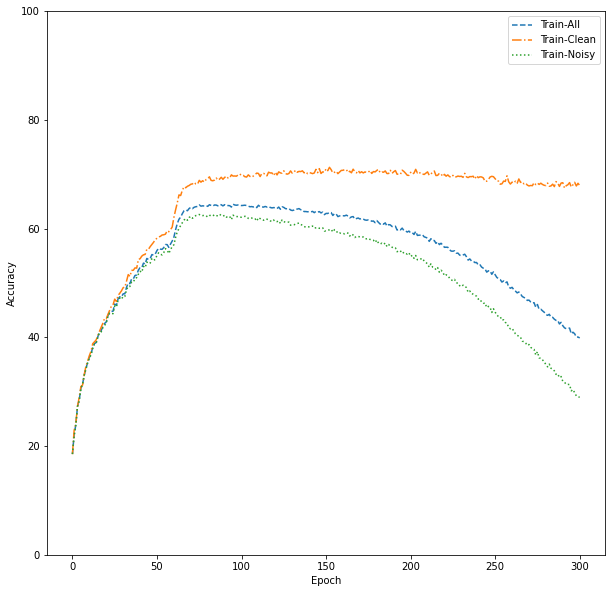

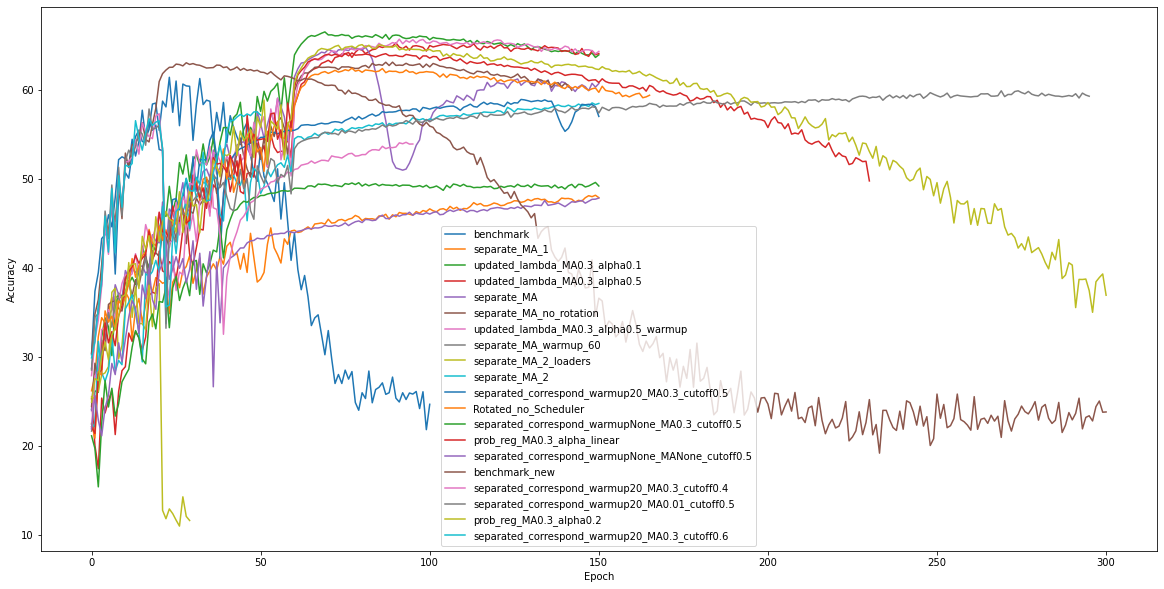

In [ ]:
model_name = 'prob_reg_MA0.3_alpha0.2'
PATH = '/content/gdrive/My Drive/DS1013NoisyLabel/results_for_0.8noise_new/'

plot_acc_train(model_name)
plot_acc_test()

In [ ]:
def plot_acc_eval():
  models = os.listdir(PATH + 'eval_results')
  writer = pd.ExcelWriter(PATH + 'eval_results/eval_results.xlsx')
  df = pd.DataFrame()
  plt.figure(figsize = (20,10))
  for model in models:
    try:
      test_acc = pd.read_pickle(os.path.join(PATH + 'eval_results', model))
      if len(test_acc.columns) == 1:
        df[model] = test_acc.iloc[:,0]
        plt.plot(test_acc, label = model)
    except Exception:
      pass
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(PATH + 'eval_results/eval_plot')
  plt.show()
  df.to_excel(writer)
  writer.save()
  writer.close()

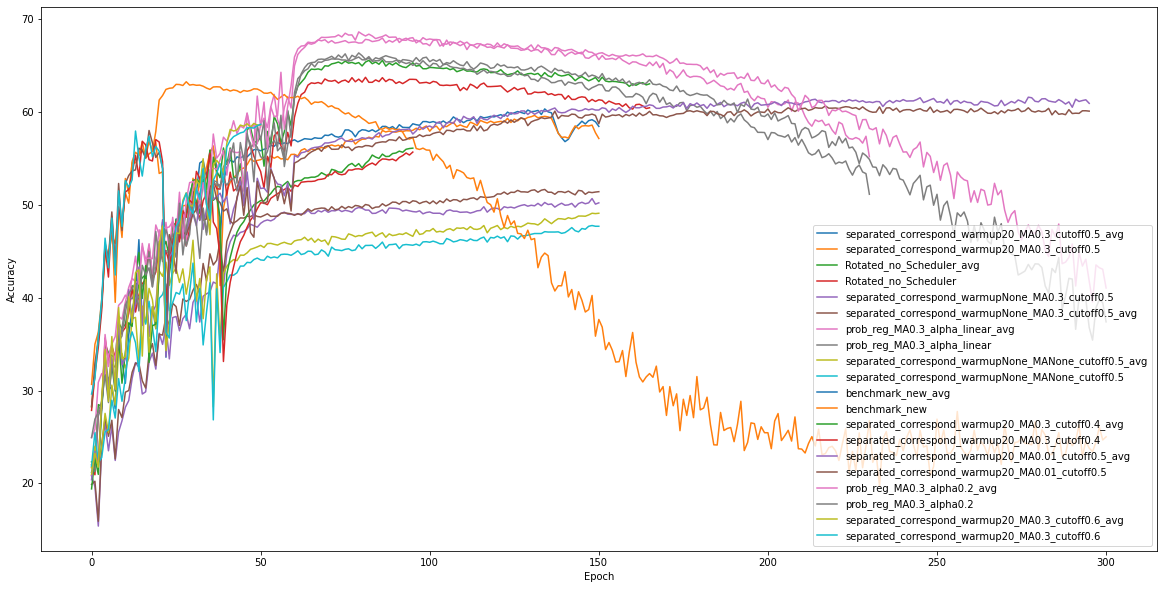

In [ ]:
plot_acc_eval()